tensor(5.9796e-06, grad_fn=<MseLossBackward0>)


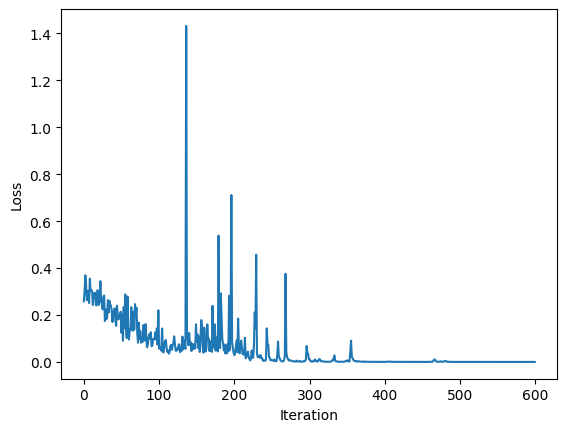

↓ → ↓ ↓ ↓  
↓ ↓ ↓ ↓ ↓  
→ ↓ ↓ ← ↓  
→ → O ← ←  
↑ → ↑ ← ←  


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils import data
import matplotlib.pyplot as plt

# Generate environment,'#' is forbidden area,'x' is target area
env = np.array([
    ['*','*','*','*','*'],
    ['*','#','#','*','*'],
    ['*','*','#','*','*'],
    ['*','#','x','#','*'],
    ['*','#','*','*','*']
])

class DQN_NN(nn.Module):
    def __init__(self):
        super(DQN_NN, self).__init__()
        self.fc1 = nn.Linear(3, 128) 
        self.fc2 = nn.Linear(128, 64) 
        self.fc3 = nn.Linear(64, 32) 
        self.fc4 = nn.Linear(32, 1) 
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

class Deep_Q_learning():
    def __init__(self, env, _lambda,k,alpha = 0.01, step = 1000,batch_size = 100,target_update_freq = 100):
        self.env = env
        self._lambda = _lambda # discount rate
        self.k = k # maximum number of iterations
        self.alpha = alpha # learning rate
        self.step = step # number of steps in each 
        self.batch_size = batch_size # batch size
        self.target_update_freq = target_update_freq # target network update frequency
       
        self.m,self.n = self.env.shape # size of the environment
        self.action_num = 5 # number of actions
        self.v = np.zeros((self.m,self.n)) # State value
        self.q = np.zeros((self.m,self.n,self.action_num)) # Action-value
        self.policy = np.zeros((self.m,self.n),dtype=int) # Target policy

        self.main_net = DQN_NN() # main network 
        self.target_net = DQN_NN() # target network
        self.target_net.load_state_dict(self.main_net.state_dict()) # initialize target network

        self.optimizer = optim.SGD(self.main_net.parameters(), lr=self.alpha) # optimizer
        self.loss_func = nn.MSELoss() # loss function

    def next_state(self,x,y,a):
        """return the next state index"""
        xx, yy = [-1, 0, 1, 0, 0], [0, 1, 0, -1, 0] # action space（up, right, down, left, stay）
        reward = 0
        isboundary = False
        x_next = x + xx[a]
        y_next = y + yy[a]
        # check the boundary
        if x_next < 0 or x_next >= self.m or y_next < 0 or y_next >= self.n: 
            x_next, y_next = x, y
            isboundary = True
        # target area
        if self.env[x_next,y_next] == 'x' and not isboundary:
            reward = 1
        # boundary area
        elif isboundary:
            reward = -1
        # forbidden area
        elif self.env[x_next,y_next] == '#': 
            reward = -1
        return x_next, y_next, reward

    def generate_episode(self):
        """generate an episode"""
        episode = []
        # generate initial state
        while True:
            x = np.random.randint(0,self.m)
            y = np.random.randint(0,self.n)
            if self.env[x,y] != '#' and self.env[x,y] != 'x':
                break
        # generate episode by uniform distribution(Πb)
        for _ in range(self.step):
            a = np.random.randint(0,self.action_num)
            x_next, y_next, reward = self.next_state(x,y,a)
            episode.append((x,y,a,reward,x_next,y_next))
            x, y = x_next, y_next
        return episode

    def draw_mini_batch(self,episode):
        """draw a mini-batch"""
        state_action = [] # (s,a)
        reward = [] # r
        next_state = [] # s'
        for i in range(len(episode)):
            state_action.append((episode[i][0],episode[i][1],episode[i][2]))
            reward.append(episode[i][3])
            next_state.append((episode[i][4],episode[i][5]))
        # transform to tensor   
        state_action = torch.tensor(state_action,dtype=torch.float32)
        reward = torch.tensor(reward).reshape(-1,1)
        next_state = torch.tensor(next_state)
        data_arrays = (state_action,reward,next_state)
        # tarnsform to dataset
        dataset = data.TensorDataset(*data_arrays)
        # draw a mini-batch
        dataloader = data.DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
        return dataloader

    def policy_update(self):
        """update the policy"""
        replay_buffer = self.generate_episode()
        # draw a mini-batch 
        dataloader = self.draw_mini_batch(replay_buffer)
        # loss display
        loss_list = []
        # train the main network
        for epoch in range(self.k):
            # update the main network
            loss = 0
            for iter,(state_action,reward,next_state) in enumerate(dataloader):
                # forword
                q_hat = self.main_net(state_action)
                q_max = torch.full((self.batch_size,1),float('-inf'))
                # found the maxq(s`,a,wT)
                for action in range(self.action_num):
                    s_a = torch.cat((next_state,torch.full((self.batch_size,1),action,dtype=torch.float32)),dim=1)
                    q_target = self.target_net(s_a)
                    q_max = torch.max(q_max,q_target)
                # calculate the y_T
                y_t = reward + self._lambda * q_max
                # calculate the loss
                loss = self.loss_func(q_hat,y_t)
                # backward
                self.optimizer.zero_grad()
                loss.backward()
                # update the parameters
                self.optimizer.step()
                # update the target network
                if iter % self.target_update_freq == 0 and iter != 0:
                    self.target_net.load_state_dict(self.main_net.state_dict())
            loss_list.append(loss.item())
        # update the policy
        for x in range(self.m):
            for y in range(self.n):
               for a in range(self.action_num):
                   s_a = torch.tensor([[x,y,a]],dtype=torch.float32)
                   q_hat = self.main_net(s_a)
                   self.q[x,y,a] = q_hat.item()
               self.policy[x,y] = np.argmax(self.q[x,y])
        # plot the loss
        print(loss)
        plt.plot(loss_list)
        plt.xlabel("Iteration")
        plt.ylabel("Loss")
        plt.show()
                
                         
    def show_policy(self):
        """show the optimal policy"""
        s = "↑→↓←O" # action display
        for x in range(self.m):
            for y in range(self.n):
                print(s[self.policy[x,y]], end=" ")
            print(" ")
    
if __name__ == "__main__":
    dqn = Deep_Q_learning(env, 
                         _lambda = 0.9, 
                         k = 600,
                         alpha = 0.1,
                         step = 1500,
                         batch_size = 100,
                         target_update_freq=10)
    dqn.policy_update()
    dqn.show_policy()
   